In [28]:
import numpy as np
import cupy as cp
import poppy

xp = cp if poppy.accel_math._USE_CUPY else np

import ray # for multiprocesing
import astropy.units as u
from astropy.io import fits
from IPython.display import clear_output
import time
from pathlib import Path
from matplotlib.patches import Circle
from importlib import reload

import warnings
warnings.filterwarnings("ignore")

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import cgi_phasec_poppy as cgi
reload(cgi)

import misc_funs as misc

npix = 310

iwa = 2.8
owa = 9.7

dm1_flat = 2*fits.getdata(cgi.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm1.fits')
dm2_flat = 2*fits.getdata(cgi.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm2.fits')

In [7]:
isinstance(psf, cp.ndarray)

True

# Test monochromatic PSFs.

Propagating wavelength 575.000 nm.
PSF calculated in 0.434s


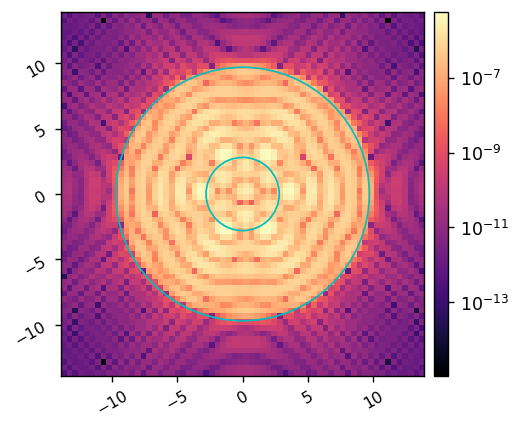

Saved data to:  C:\Users\Kian\Documents\data-files\roman-cgi-phasec-data\hlc_psf_gpu.fits


In [39]:
reload(cgi)
mode = cgi.CGI(cgi_mode='hlc', 
               use_pupil_defocus=True, 
               use_opds=False,
               polaxis=0)

wf = mode.calc_psf(quiet=False)
psf = np.abs(wf)**2

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.imshow1(psf, lognorm=True, pxscl=mode.psf_pixelscale_lamD, patches=patches)

if poppy.accel_math._USE_CUPY:
    misc.save_fits(cgi.data_dir/'hlc_psf_gpu.fits', psf, header={'PIXELSCL':mode.psf_pixelscale_lamD})
else:
    misc.save_fits(cgi.data_dir/'hlc_psf_cpu.fits', psf, header={'PIXELSCL':mode.psf_pixelscale_lamD})

In [3]:
%%timeit
wf = mode.calc_psf(quiet=True)

269 ms ± 1.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Propagating wavelength 575.000 nm.
PSF calculated in 0.387s


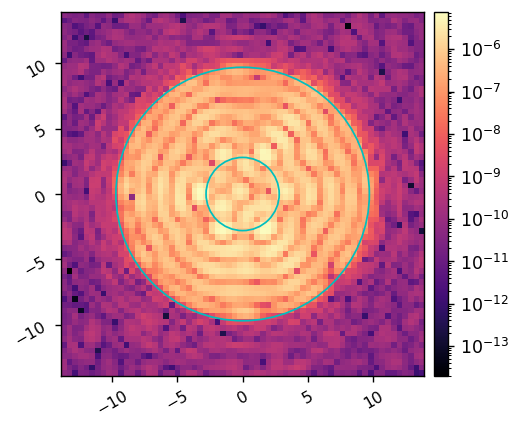

Saved data to:  C:\Users\Kian\Documents\data-files\roman-cgi-phasec-data\hlc_opds_psf_gpu.fits


In [4]:
mode = cgi.CGI(cgi_mode='hlc', 
               use_pupil_defocus=True, 
               use_opds=True,
               polaxis=10)

mode.set_dm1(dm1_flat)
mode.set_dm2(dm2_flat)

wf = mode.calc_psf(quiet=False)
psf = np.abs(wf)**2

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.imshow1(psf, lognorm=True, pxscl=mode.psf_pixelscale_lamD, patches=patches)

if poppy.accel_math._USE_CUPY:
    misc.save_fits(cgi.data_dir/'hlc_opds_psf_gpu.fits', psf, header={'PIXELSCL':mode.psf_pixelscale_lamD})
else:
    misc.save_fits(cgi.data_dir/'hlc_opds_psf_cpu.fits', psf, header={'PIXELSCL':mode.psf_pixelscale_lamD})

In [18]:
%%timeit
wf = mode.calc_psf(quiet=True)

311 ms ± 810 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Test broadband PSFs with GPU parallelization.

### Create the actors to calculate each individual PSF/image with ray.remote() actors.

num_gpus can be set to whatever fractional GPU the user desires, but this can cause issues when using many actors at once. For example, if your GPU doesn't have the computational capabilities or memory to assign each actor to 1/10 of the GPU, than this will make the code run slower, not faster.

In [5]:
reload(cgi)
rayCGI = ray.remote(cgi.CGI) # make a ray actor class from the original CGI class  

wavelength_c = 575e-9*u.m

nlam = 3
bandwidth = 0.10
minlam = wavelength_c * (1 - bandwidth/2)
maxlam = wavelength_c * (1 + bandwidth/2)
wavelengths = np.linspace( minlam, maxlam, nlam )

kwargs = {'cgi_mode':'hlc',
          'use_pupil_defocus':True,
          'use_opds':True}
actors = []
for i in range(nlam):
    actors.append(rayCGI.remote(wavelength=wavelengths[i], **kwargs))

### Calculate each image by calling the remote function of each actor. 

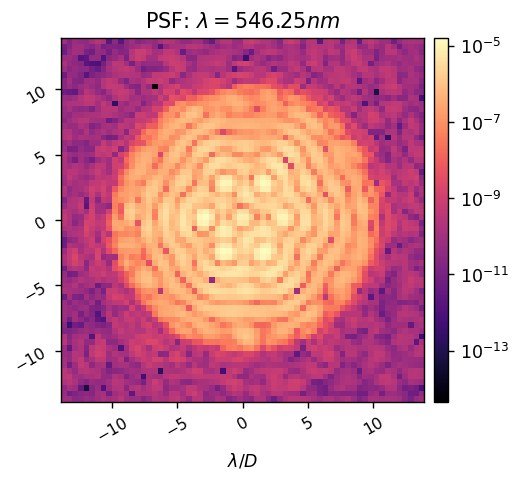

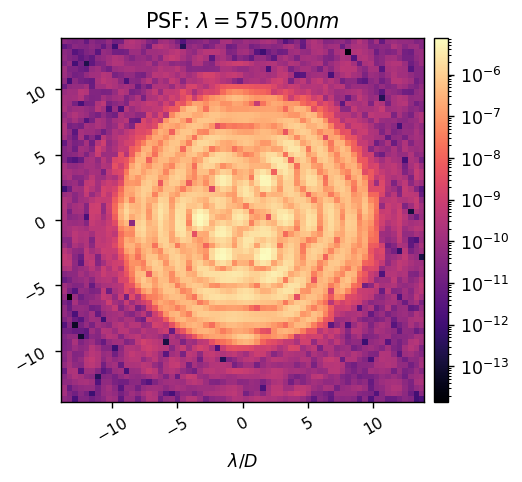

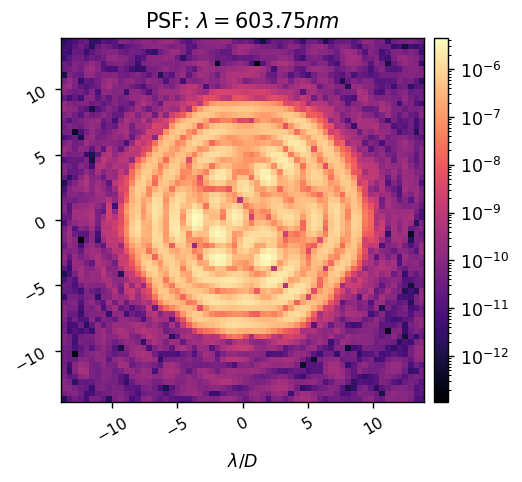

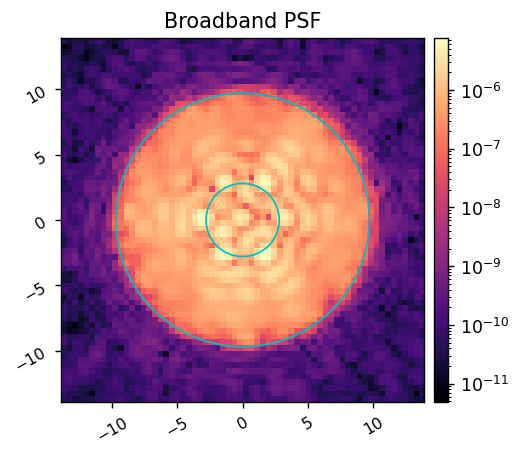

Saved data to:  C:\Users\Kian\Documents\data-files\roman-cgi-phasec-data\hlc_psf_broad_gpu.fits


In [8]:
pending_ims = []
for i in range(len(actors)):
    actors[i].set_dm1.remote(dm1_flat) # set the DM state for each actor in this loop
    actors[i].set_dm2.remote(dm2_flat)
    future_ims = actors[i].snap.remote()
    pending_ims.append(future_ims)
ims = xp.array(ray.get(pending_ims))
clear_output()

for i in range(len(actors)):
    misc.imshow1(ims[i], 
                 'PSF: $\lambda={:.2f}$'.format(ray.get(actors[i].getattr.remote('wavelength')).to(u.nm)), 
                 pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$',
                 lognorm=True)
    
psf_broad = xp.sum(ims, axis=0)/nlam

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.imshow1(psf_broad, 'Broadband PSF', lognorm=True, pxscl=mode.psf_pixelscale_lamD, patches=patches)

if poppy.accel_math._USE_CUPY:
    misc.save_fits(cgi.data_dir/'hlc_psf_broad_gpu.fits', psf_broad, header={'PIXELSCL':mode.psf_pixelscale_lamD})
else:
    misc.save_fits(cgi.data_dir/'hlc_psf_broad_cpu.fits', psf_broad, header={'PIXELSCL':mode.psf_pixelscale_lamD})

# Compute different polarization PSFs in parallel.

In [9]:
reload(cgi)
rayCGI = ray.remote(cgi.CGI)
kwargs = {'cgi_mode':'hlc',
          'use_pupil_defocus':True,
          'use_opds':True}
polaxis = [-2, -1, 1, 2]
actors = []
for i in range(len(polaxis)):
    actors.append(rayCGI.remote(polaxis=polaxis[i], **kwargs))

 pid=24284) After resampling, optic phasor shape (636, 636) is smaller than input wavefront (1024, 1024); will zero-pad the rescaled array.
 pid=24284) After resampling, optic phasor shape (636, 636) is smaller than input wavefront (1024, 1024); will zero-pad the rescaled array.


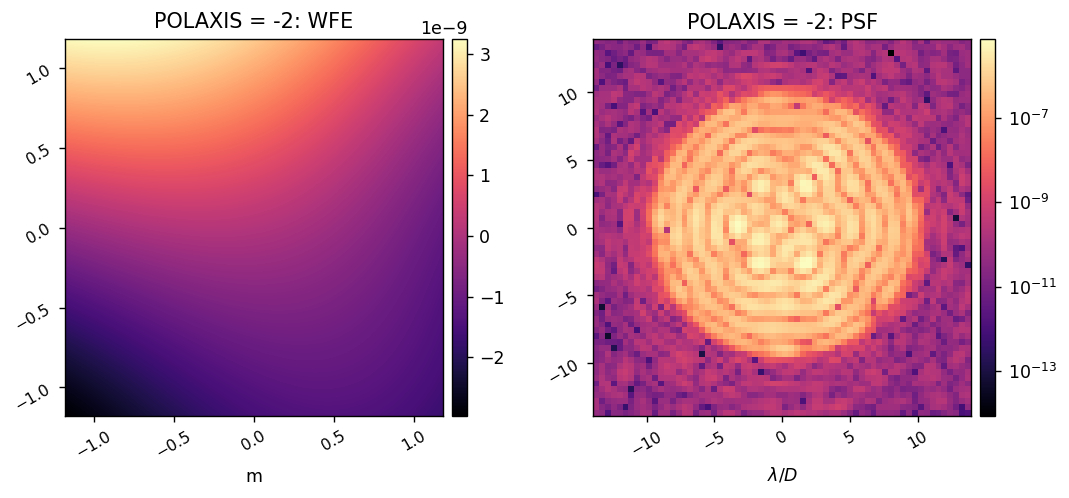

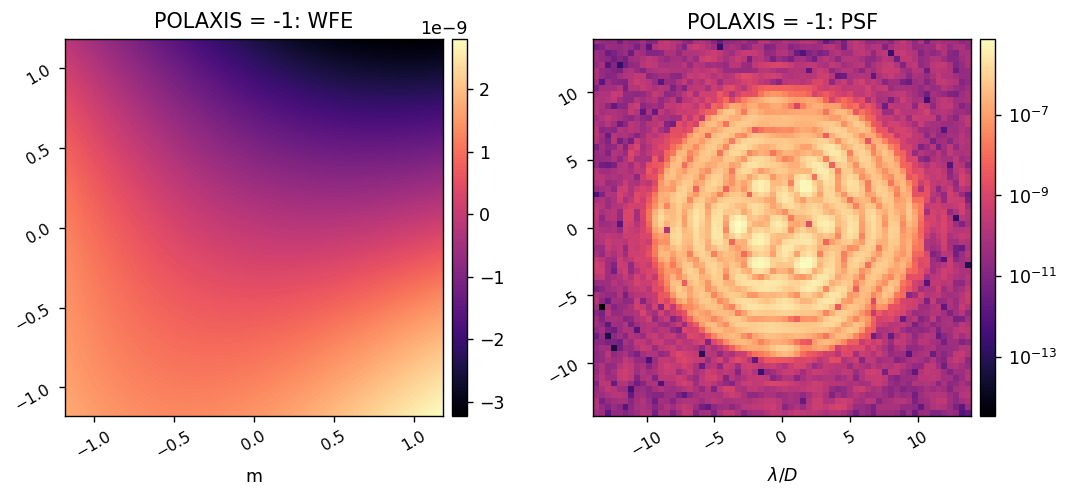

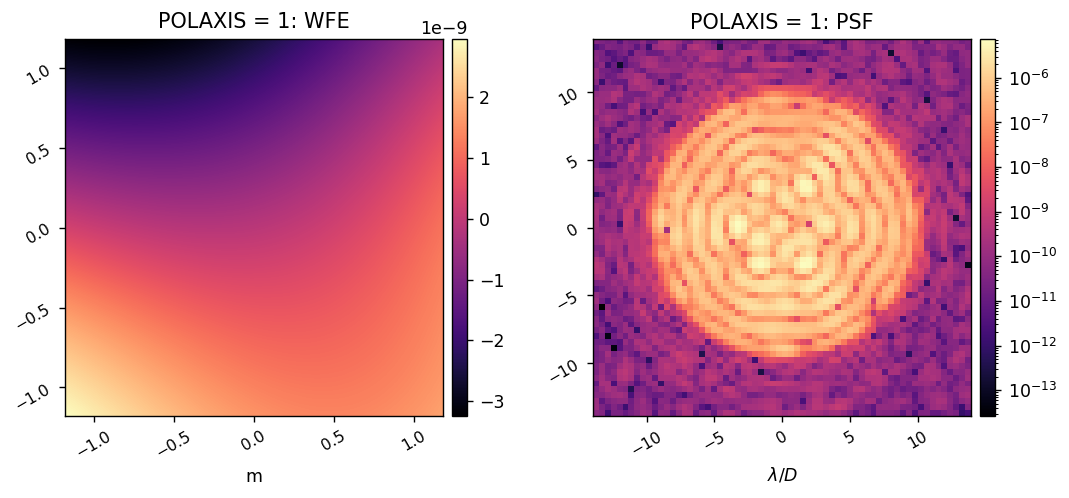

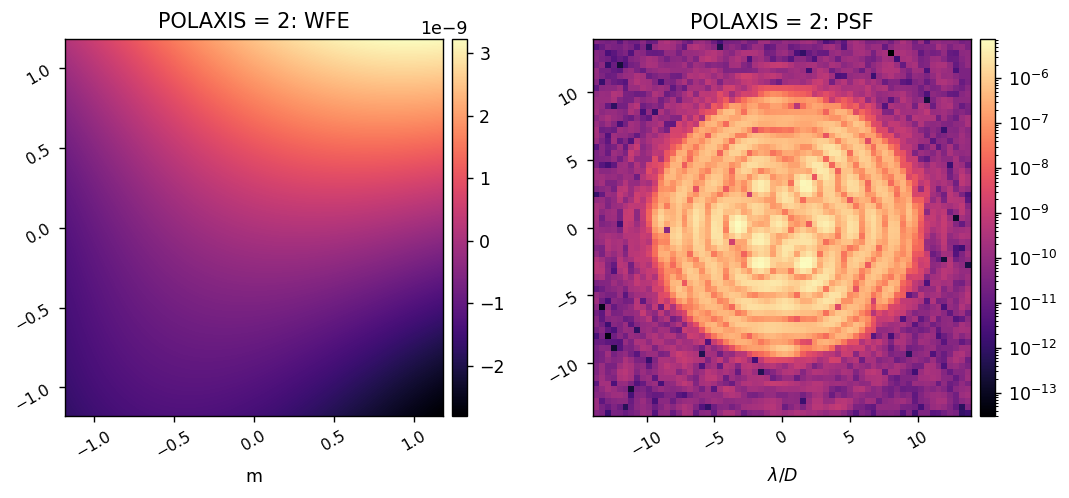

In [34]:
pending_ims = []
for i in range(len(actors)):
    actors[i].set_dm1.remote(dm1_flat) # set the DM state for each actor in this loop
    actors[i].set_dm2.remote(dm2_flat)
    future_ims = actors[i].snap.remote()
    pending_ims.append(future_ims)
ims = ray.get(pending_ims)
clear_output()

for i in range(len(actors)):
    polmap = ray.get(actors[i].getattr.remote('POLMAP'))
    pol_wfe = misc.pad_or_crop(polmap.opd, npix)
    
    misc.imshow2(pol_wfe, ims[i], 
                 'POLAXIS = {:d}: WFE'.format(ray.get(actors[i].getattr.remote('polaxis'))), 
                 'POLAXIS = {:d}: PSF'.format(ray.get(actors[i].getattr.remote('polaxis'))), 
                 pxscl1=mode.pupil_diam/mode.npix, xlabel1='m',
                 pxscl2=mode.psf_pixelscale_lamD, xlabel2='$\lambda/D$',
                 lognorm2=True)

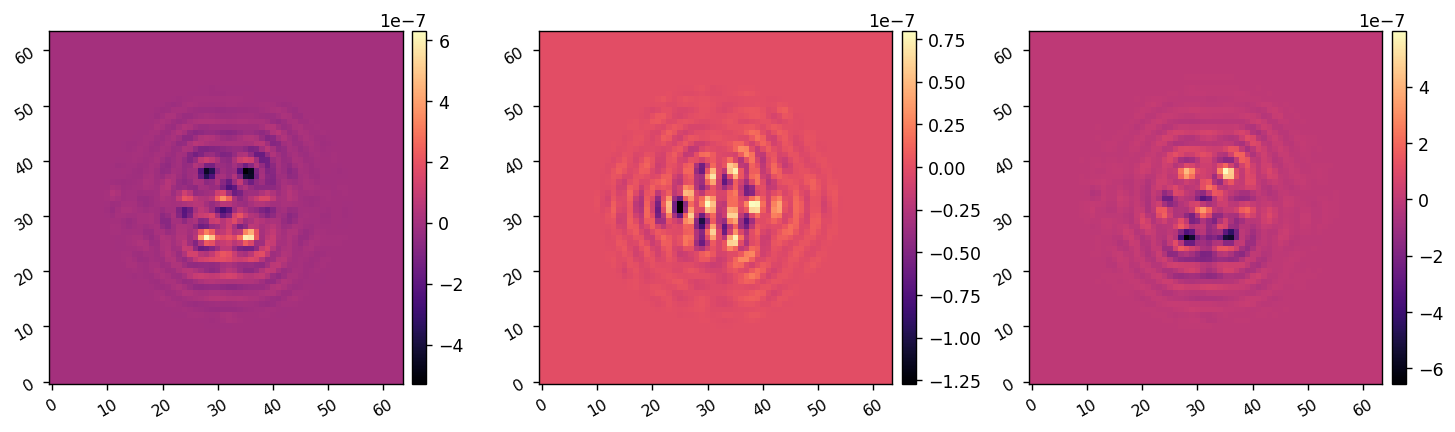

In [19]:
misc.imshow3(ims[0]-ims[1], ims[1]-ims[2], ims[1]-ims[3])